In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/nx414')
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
# import gdown
# url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
# output = "IT_data.h5"
# gdown.download(url, output, quiet=False, fuzzy=True)

Mounted at /content/drive


In [3]:
# What model you want to use?
my_model = "pretrained"
# my_model = "random"

# Have you already obtained the primary components?
# need_to_extract_pca = "False"
need_to_extract_pca = "True"

### Load the data

In [2]:
path_to_data = '/content/drive/MyDrive/nx414' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [4]:
y_train = spikes_train
y_val = spikes_val

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import explained_variance_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
X_train = stimulus_train.reshape(stimulus_train.shape[0], -1)  # Flatten RGB channels and spatial dimensions
X_val = stimulus_val.reshape(stimulus_val.shape[0], -1)
y_train = spikes_train
y_val = spikes_val

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
pca = PCA(n_components=1000)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [ ]:
print(f"Input shape after flattening: {X_train.shape}")
print(f"Output shape (neural activity): {y_train.shape}")

Input shape after flattening: (2592, 150528)
Output shape (neural activity): (2592, 168)


### 1. Simple Linear Regression

In [ ]:
correlations = []
exp_variances = []

for neuron in tqdm(range(y_train.shape[1]), desc="Training models for neurons"):
    # Train linear regression for each neuron
    lr = LinearRegression()
    lr.fit(X_train_pca, y_train[:, neuron])

    # Predict on validation set
    y_pred = lr.predict(X_val_pca)
    y_true = y_val[:, neuron]

    # Calculate correlation
    correlation = np.corrcoef(y_pred, y_true)[0, 1]
    correlations.append(correlation)

    # Calculate explained variance
    exp_var = explained_variance_score(y_true, y_pred)
    exp_variances.append(exp_var)

Training models for neurons: 100%|██████████| 168/168 [01:06<00:00,  2.54it/s]


In [ ]:
print(np.mean(correlations))
print(np.mean(exp_variances))

0.21915666399254524
-0.07273741988908677


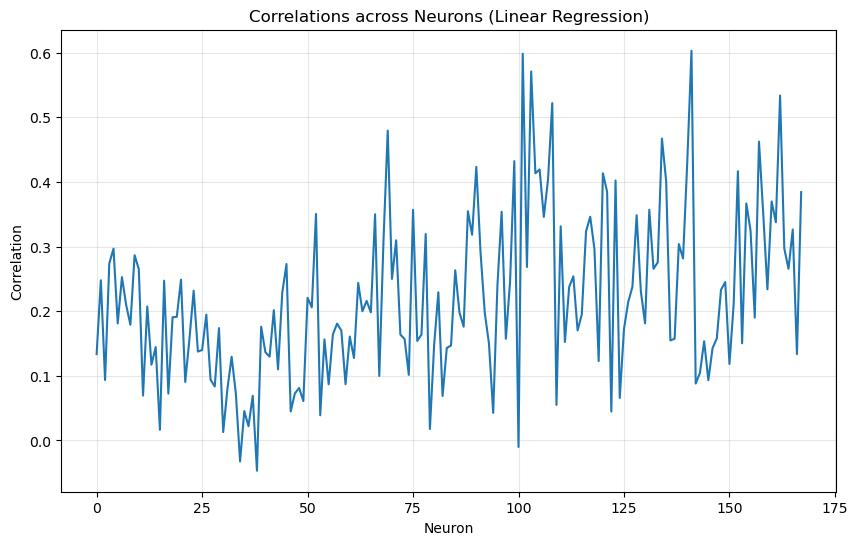

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(correlations)), correlations)
plt.xlabel('Neuron')
plt.ylabel('Correlation')
plt.title('Correlations across Neurons (Linear Regression)')
plt.grid(True, alpha=0.3)
plt.show()

### 2 Ridge

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
# use stratified split in training data (not labels) according to the object shape
# 5 fold CV

def get_stratified_splits(objects, n_splits=5):
    unique_objects = np.unique(objects)
    object_indices = {obj: np.where(np.array(objects) == obj)[0] for obj in unique_objects}

    all_splits = []
    for _ in range(n_splits):
        train_idx = []
        val_idx = []

        for obj, indices in object_indices.items():
            # Randomly select 80% for training and 20% for validation
            np.random.shuffle(indices)
            split_point = int(len(indices) * 0.8)
            train_idx.extend(indices[:split_point])
            val_idx.extend(indices[split_point:])

        all_splits.append((train_idx, val_idx))

    return all_splits

In [ ]:
# 300000 > 464158 > 1000000

alphas = np.array([150000, 200000, 250000,300000])
alphas

array([150000, 200000, 250000, 300000])

In [ ]:
best_alphas = []
best_exp_variances = []
best_correlations_ridge = []

for neuron in range(y_train.shape[1]):
    best_score = -np.inf
    best_alpha = None

    for alpha in alphas:
        cv_scores = []
        splits = get_stratified_splits(objects_train, n_splits=5)

        for train_idx, val_idx in splits:
            # train and val data
            X_train_fold = X_train_pca[train_idx]
            y_train_fold = y_train[train_idx, neuron]
            X_val_fold = X_train_pca[val_idx]
            y_val_fold = y_train[val_idx, neuron]

            # ridge
            ridge = Ridge(alpha=alpha)
            ridge.fit(X_train_fold, y_train_fold)

            # eval
            y_pred_fold = ridge.predict(X_val_fold)
            score = explained_variance_score(y_val_fold, y_pred_fold)
            cv_scores.append(score)

        # average score across folds
        mean_score = np.mean(cv_scores)

        # update best alpha
        if mean_score > best_score:
            best_score = mean_score
            best_alpha = alpha

    # final model with best alpha on full training data
    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X_train_pca, y_train[:, neuron])


    # eval
    y_pred = ridge.predict(X_val_pca)
    exp_var = explained_variance_score(y_val[:, neuron], y_pred)
    correlation = np.corrcoef(y_pred, y_val[:, neuron])[0, 1]

    best_alphas.append(best_alpha)
    best_exp_variances.append(exp_var)
    best_correlations_ridge.append(correlation)

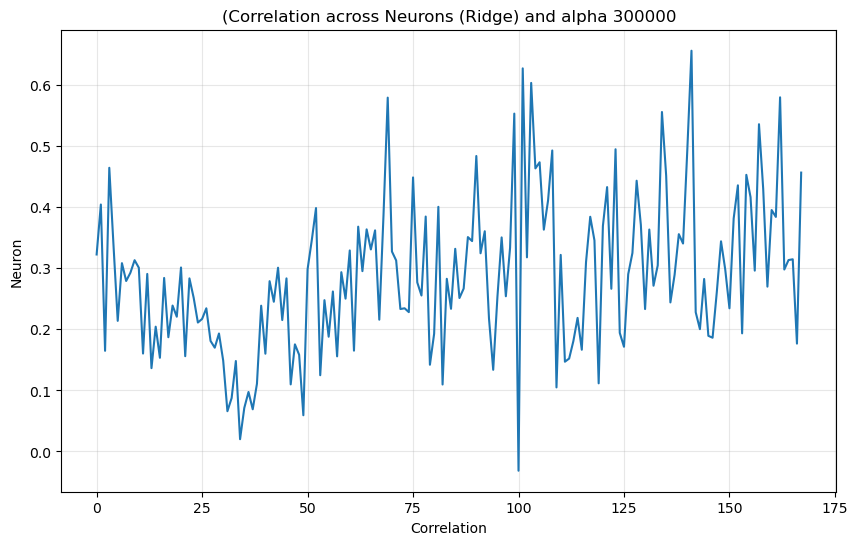

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(best_correlations_ridge)), best_correlations_ridge)
plt.xlabel('Correlation')
plt.ylabel('Neuron')
plt.title(f'(Correlation across Neurons (Ridge) and alpha {best_alpha}')
plt.grid(True, alpha=0.3)
plt.show()

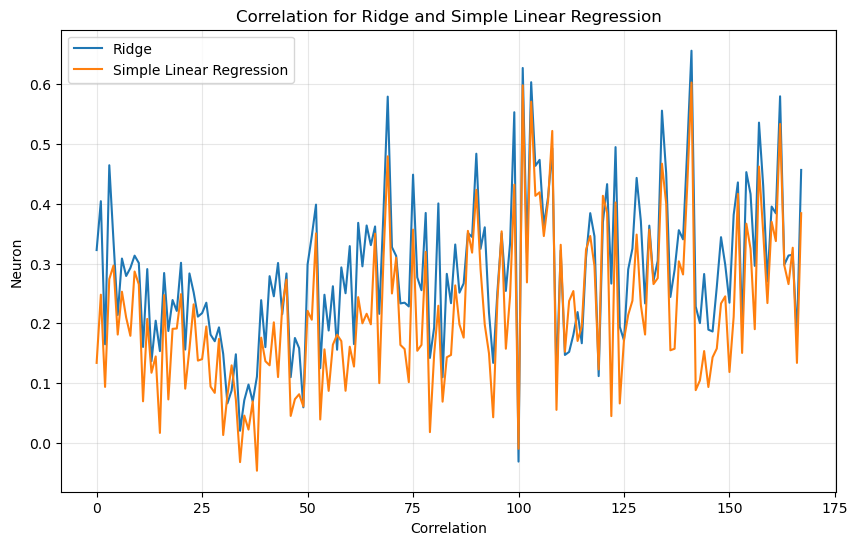

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(best_correlations_ridge)), best_correlations_ridge, label='Ridge')
plt.plot(range(len(correlations)), correlations, label='Simple Linear Regression')
plt.xlabel('Correlation')
plt.ylabel('Neuron')
plt.title(f'Correlation for Ridge and Simple Linear Regression')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [5]:
import torch
from torch import nn
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
import gc
import pickle

In [6]:
# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA available: Yes")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA available: No")


PyTorch version: 2.6.0+cu124
CUDA available: Yes
CUDA version: 12.4
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: NVIDIA L4


In [7]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, layers):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.get_hook(layer_id))

    def get_hook(self, layer_id):
        def hook(module, input, output):
            self._features[layer_id] = output
        return hook

    def forward(self, x):
        self.model(x)
        return [self._features[layer_id] for layer_id in self.layers]

### 2.1 initialize pretrained resnet or random resnet

In [11]:
from torchvision.models import mobilenet_v2
if my_model == "pretrained":
    #pretrained_model = models.resnet50(pretrained=True)
    device = "cuda"

    pretrained_model = mobilenet_v2(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

else:
    random_model = models.resnet50(pretrained=False)
    random_model.eval()

print(f"==========================")
print(f"==========================")
print(f"Model used is {my_model} mobilenetv2")
print(f"==========================")
print(f"==========================")

Model used is pretrained mobilenetv2


In [16]:
pretrained_model.features[1]

InvertedResidual(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [31]:
layers_to_extract = [
    'features.0',         # Initial Conv
    'features.5',         # First expansion block
    'features.10',         # Mid-depth block
    'features.14',        # Deeper still
    'features.18',        # Final Conv before pooling
]

In [19]:
# Convert HxWxC numpy images to CxHxW torch tensors
def preprocess_images(images):
    # Images are already normalized in the dataset
    # Convert to torch tensor and adjust dimensions
    images_tensor = torch.tensor(images, dtype=torch.float32)
    # Our images are already in the format [batch, channels, height, width]
    return images_tensor

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
def extract_features(model, stimulus, batch_size=128):
    # Create feature extractor
    extractor = FeatureExtractor(model, layers_to_extract)
    extractor.to(device)
    extractor.eval()

    results = {}

    # Process one layer at a time
    for layer_name in layers_to_extract:
        print(f"\nProcessing layer: {layer_name}")

        # Create DataLoader
        dataset = TensorDataset(preprocess_images(stimulus))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        # Collect activations
        layer_activations = []

        with torch.no_grad():
            for batch in tqdm(dataloader, desc=f"Extracting {layer_name}"):
                batch = batch[0].to(device)
                # Call the entire model to get all activations
                activations = extractor(batch)
                # Find the index of the current layer
                layer_idx = layers_to_extract.index(layer_name)
                # Get activations for the current layer
                layer_act = activations[layer_idx].cpu().numpy()

                # Flatten
                if len(layer_act.shape) > 2:
                    if layer_name == 'avgpool':
                        layer_act = layer_act.reshape(layer_act.shape[0], -1)
                    else:
                        layer_act = layer_act.reshape(layer_act.shape[0], -1)

                layer_activations.append(layer_act)

        # Combine batches
        layer_act = np.vstack(layer_activations)

        # Store original features
        results[layer_name] = {
            'features': layer_act
        }

        # ===============
        # clean up memory
        del layer_activations, layer_act
        gc.collect()
        torch.cuda.empty_cache()

    # Clean up extractor
    del extractor
    gc.collect()
    torch.cuda.empty_cache()

    return results

In [34]:
def apply_pca_to_features(train_features, val_features, n_components=1000):
    train_pcs = {}
    val_pcs = {}

    for layer_name in layers_to_extract:
        X_train = train_features[layer_name]['features']
        X_val = val_features[layer_name]['features']

        # If n_components is greater than or equal to the feature dimensions, skip PCA
        if n_components >= X_train.shape[1]:
            print(f"Layer {layer_name}: Skipping PCA as n_components ({n_components}) >= feature dimensions ({X_train.shape[1]})")
            train_pcs[layer_name] = {
                'pcs': X_train,
                'scaler': None,
                'pca': None
            }
            val_pcs[layer_name] = {
                'pcs': X_val
            }
            continue

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)  # 使用相同的scaler

        n_comp = min(n_components, X_train.shape[0], X_train.shape[1])
        pca = PCA(n_components=n_comp)
        train_pcs[layer_name] = {
            'pcs': pca.fit_transform(X_train_scaled),
            'scaler': scaler,
            'pca': pca
        }

        val_pcs[layer_name] = {
            'pcs': pca.transform(X_val_scaled)
        }

        print(f"Layer {layer_name}: {n_comp} components, {sum(pca.explained_variance_ratio_):.4f} variance explained")

    return train_pcs, val_pcs

In [35]:
need_to_extract_pca,my_model

('True', 'pretrained')

In [36]:
for name, _ in pretrained_model.named_modules():
    print(name)


features
features.0
features.0.0
features.0.1
features.0.2
features.1
features.1.conv
features.1.conv.0
features.1.conv.0.0
features.1.conv.0.1
features.1.conv.0.2
features.1.conv.1
features.1.conv.2
features.2
features.2.conv
features.2.conv.0
features.2.conv.0.0
features.2.conv.0.1
features.2.conv.0.2
features.2.conv.1
features.2.conv.1.0
features.2.conv.1.1
features.2.conv.1.2
features.2.conv.2
features.2.conv.3
features.3
features.3.conv
features.3.conv.0
features.3.conv.0.0
features.3.conv.0.1
features.3.conv.0.2
features.3.conv.1
features.3.conv.1.0
features.3.conv.1.1
features.3.conv.1.2
features.3.conv.2
features.3.conv.3
features.4
features.4.conv
features.4.conv.0
features.4.conv.0.0
features.4.conv.0.1
features.4.conv.0.2
features.4.conv.1
features.4.conv.1.0
features.4.conv.1.1
features.4.conv.1.2
features.4.conv.2
features.4.conv.3
features.5
features.5.conv
features.5.conv.0
features.5.conv.0.0
features.5.conv.0.1
features.5.conv.0.2
features.5.conv.1
features.5.conv.1.0

In [37]:
if need_to_extract_pca:
    if my_model == "pretrained":
        print("Extracting features from pre-trained model...")
        pretrained_features_train = extract_features(pretrained_model, stimulus_train)
        pretrained_features_val = extract_features(pretrained_model, stimulus_val)
    else:
        print("Extracting features from randomly initialized model...")
        random_features_train = extract_features(random_model, stimulus_train)
        random_features_val = extract_features(random_model, stimulus_val)
else:
    print("No need to extract features")

Extracting features from pre-trained model...

Processing layer: features.0


Extracting features.0: 100%|██████████| 21/21 [00:05<00:00,  4.04it/s]



Processing layer: features.5


Extracting features.5: 100%|██████████| 21/21 [00:02<00:00,  8.33it/s]



Processing layer: features.10


Extracting features.10: 100%|██████████| 21/21 [00:02<00:00,  8.90it/s]



Processing layer: features.14


Extracting features.14: 100%|██████████| 21/21 [00:02<00:00,  9.28it/s]



Processing layer: features.18


Extracting features.18: 100%|██████████| 21/21 [00:02<00:00,  7.65it/s]



Processing layer: features.0


Extracting features.0: 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]



Processing layer: features.5


Extracting features.5: 100%|██████████| 3/3 [00:00<00:00, 11.48it/s]



Processing layer: features.10


Extracting features.10: 100%|██████████| 3/3 [00:00<00:00, 11.71it/s]



Processing layer: features.14


Extracting features.14: 100%|██████████| 3/3 [00:00<00:00, 11.43it/s]



Processing layer: features.18


Extracting features.18: 100%|██████████| 3/3 [00:00<00:00, 10.97it/s]


In [38]:
if need_to_extract_pca == "True":
    print(f"Extracting PCA from {my_model} model...")
    if my_model == "pretrained":
        pretrained_pcs_train, pretrained_pcs_val = apply_pca_to_features(
            pretrained_features_train,
            pretrained_features_val,
            n_components=1000
        )
    else:
        random_pcs_train, random_pcs_val = apply_pca_to_features(
            random_features_train,
            random_features_val,
            n_components=1000
        )
else:
    print("No need to extract PCA from features")

Extracting PCA from pretrained model...
Layer features.0: 1000 components, 0.8668 variance explained
Layer features.5: 1000 components, 0.8156 variance explained
Layer features.10: 1000 components, 0.8729 variance explained
Layer features.14: 1000 components, 0.9169 variance explained
Layer features.18: 1000 components, 0.8196 variance explained


In [ ]:
if need_to_extract_pca == "True":
    if my_model == "pretrained":
        print("Saving pretrained PCA...")
        with open('pretrained_pcs.pkl', 'wb') as f:
            pickle.dump((pretrained_pcs_train, pretrained_pcs_val), f)
    else:
        print("Saving random PCA...")
        with open('random_pcs.pkl', 'wb') as f:
            pickle.dump((random_pcs_train, random_pcs_val), f)
else:
    if my_model == "pretrained":
        print("Loading pretrained PCA...")
        with open('pretrained_pcs.pkl', 'rb') as f:
            pretrained_pcs_train, pretrained_pcs_val = pickle.load(f)
    else:
        print("Loading random PCA...")
        with open('random_pcs.pkl', 'rb') as f:
            random_pcs_train, random_pcs_val = pickle.load(f)

print("===============")
print("Completed")

Loading pretrained PCA...
Completed


### 2.2 Now train regressors

- read in train_pc
- train regressor
- test
- return a sample (for visualization purpose)
- return metrics

What are these metrics returned?
- 1. a vector of size n, correlations for all n neurons
- 2. a vector of size n, exp_variances for all nn eurons
- for these neurons, we obtain the average
    - 3. a scalar of mean correlation
    - 4. a scalar of mean variance

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from tqdm import tqdm

In [40]:
def predict_neural_activity(layer_pcs_train, layer_pcs_val, y_train, y_val, sample_to_plot=0):
    layer_metrics = {}
    sample_predictions = {}

    for layer_name in layers_to_extract:
        print(f"Predicting neural activity using {layer_name}")
        X_train_pcs = layer_pcs_train[layer_name]['pcs']
        X_val_pcs = layer_pcs_val[layer_name]['pcs']


        if X_train_pcs.shape[1] != X_val_pcs.shape[1]:
            print(f"Warning: Feature mismatch for {layer_name}. Training: {X_train_pcs.shape[1]}, Validation: {X_val_pcs.shape[1]}")
            min_components = min(X_train_pcs.shape[1], X_val_pcs.shape[1])
            X_train_pcs = X_train_pcs[:, :min_components]
            X_val_pcs = X_val_pcs[:, :min_components]
            print(f"Using {min_components} components for both sets")

        correlations = []
        exp_variances = []
        sample_neuron_predictions = []  # Store predictions for all neurons for a specific sample

        for neuron in tqdm(range(y_train.shape[1]), desc=f"Training models for {layer_name}"):
            # Train linear regression
            lr = LinearRegression()
            lr.fit(X_train_pcs, y_train[:, neuron])

            # Predict on validation set
            y_pred = lr.predict(X_val_pcs)
            y_true = y_val[:, neuron]

            # Calculate correlation and explained variance
            correlation = np.corrcoef(y_pred, y_true)[0, 1]
            exp_var = explained_variance_score(y_true, y_pred)

            correlations.append(correlation)
            exp_variances.append(exp_var)

            # Save prediction for the specific sample
            sample_neuron_predictions.append(y_pred[sample_to_plot])

        layer_metrics[layer_name] = {
            'correlations': correlations,
            'exp_variances': exp_variances,
            'mean_correlation': np.mean(correlations),
            'mean_exp_variance': np.mean(exp_variances)
        }

        sample_predictions[layer_name] = np.array(sample_neuron_predictions)

        print(f"Mean correlation for {layer_name}: {np.mean(correlations):.4f}")
        print(f"Mean explained variance for {layer_name}: {np.mean(exp_variances):.4f}")


    # PLOT a single case just to visualize... not that meaningful tho

    # Plot predictions for all neurons from each layer for a specific sample
    plt.figure(figsize=(14, 7))

    # Plot true values
    neurons = np.arange(y_val.shape[1])
    plt.plot(neurons, y_val[sample_to_plot], 'ko-', label='True Activity', linewidth=2)

    # Plot predictions from each layer
    colors = plt.cm.tab10(np.linspace(0, 1, len(layers_to_extract)))
    for i, layer_name in enumerate(layers_to_extract):
        plt.plot(neurons, sample_predictions[layer_name], 'o-',
                 color=colors[i], label=f'{layer_name} Prediction',
                 alpha=0.8)

    plt.title(f'Neural Activity Predictions for Sample {sample_to_plot}')
    plt.xlabel('Neuron Number')
    plt.ylabel('Neural Activity')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('all_layer_predictions.png')
    plt.show()

    return layer_metrics


Predicting with pre-trained model features...
Predicting neural activity using features.0


Training models for features.0: 100%|██████████| 168/168 [01:01<00:00,  2.72it/s]


Mean correlation for features.0: 0.1826
Mean explained variance for features.0: -1.6615
Predicting neural activity using features.5


Training models for features.5: 100%|██████████| 168/168 [01:01<00:00,  2.74it/s]


Mean correlation for features.5: 0.4971
Mean explained variance for features.5: 0.2443
Predicting neural activity using features.10


Training models for features.10: 100%|██████████| 168/168 [01:01<00:00,  2.75it/s]


Mean correlation for features.10: 0.5381
Mean explained variance for features.10: 0.2786
Predicting neural activity using features.14


Training models for features.14: 100%|██████████| 168/168 [01:03<00:00,  2.66it/s]


Mean correlation for features.14: 0.5897
Mean explained variance for features.14: 0.3261
Predicting neural activity using features.18


Training models for features.18: 100%|██████████| 168/168 [01:01<00:00,  2.72it/s]


Mean correlation for features.18: 0.5871
Mean explained variance for features.18: 0.3448


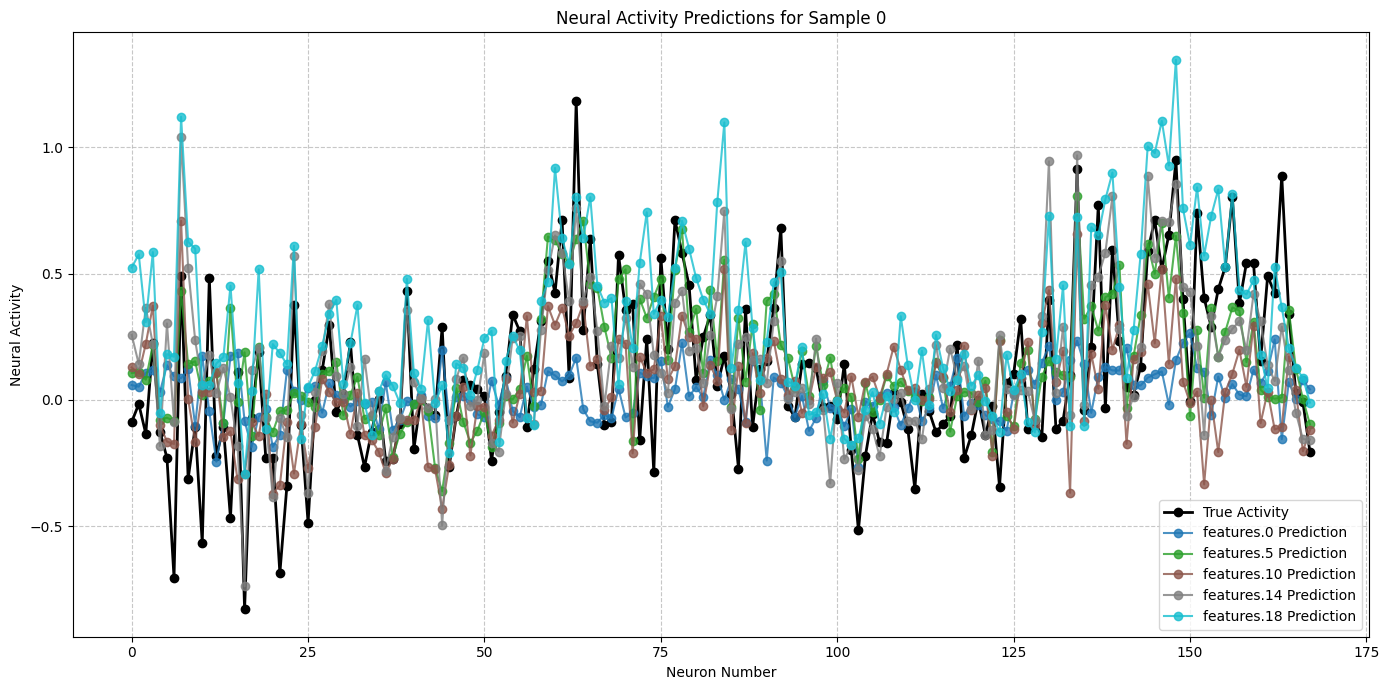

In [41]:
if my_model == "pretrained":
    print("Predicting with pre-trained model features...")
    layer_metrics = predict_neural_activity(pretrained_pcs_train, pretrained_pcs_val, y_train, y_val)
else:
    print("Predicting with randomly initialized model features...")
    layer_metrics = predict_neural_activity(random_pcs_train, random_pcs_val, y_train, y_val)

In [42]:
def plot_layer_metrics(my_model, layer_metrics, metric='exp_variances'):
    # Calculate mean metrics for each layer
    layers = layers_to_extract

    # Map metric parameter to the actual keys in the metrics dictionaries
    if metric == 'exp_variances' or metric == 'exp_variance':
        mean_key = 'mean_exp_variance'
        dist_key = 'exp_variances'
    elif metric == 'correlation':
        mean_key = 'mean_correlation'
        dist_key = 'correlations'
    else:
        mean_key = f'mean_{metric}'
        dist_key = metric

    # Prepare x-axis with layer names
    x = np.arange(len(layers))
    width = 0.35

    # Create plot
    plt.figure(figsize=(12, 6))

    # Get means for the model type
    model_means = [layer_metrics[layer][mean_key] for layer in layers]

    # Plot based on model type
    if my_model == "pretrained":
        plt.bar(x, model_means, width, label='Pre-trained')
    elif my_model == "random":
        plt.bar(x, model_means, width, label='Random')

    plt.xlabel('Network Layer')
    plt.ylabel('Mean ' + ('Correlation' if 'correlation' in metric else 'Explained Variance'))
    plt.title('Performance Across Layers')
    plt.xticks(x, layers, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

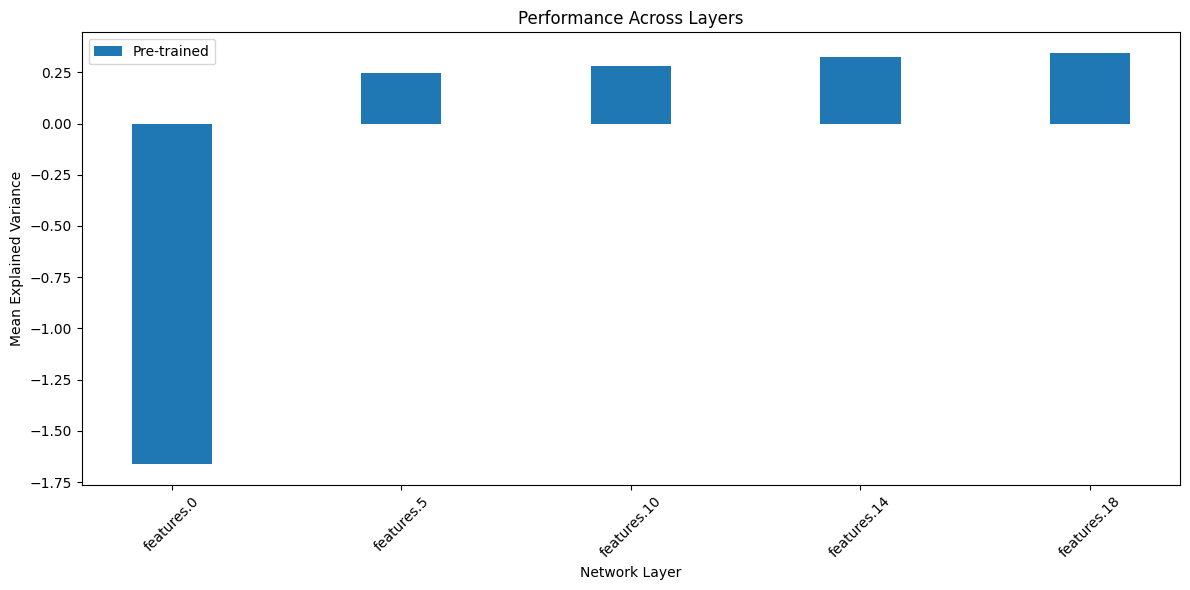

In [45]:
plot_layer_metrics(my_model, layer_metrics=layer_metrics, metric='exp_variances')

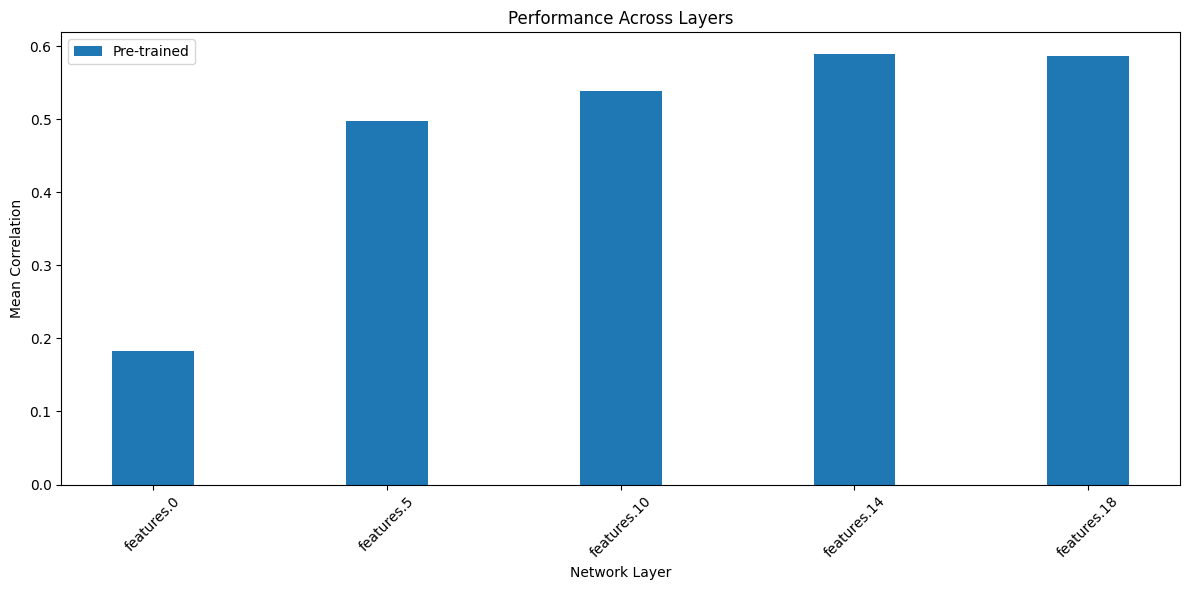

In [46]:
plot_layer_metrics(my_model, layer_metrics=layer_metrics, metric='correlation')